In [160]:
import numpy as np
import glob,os
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times',size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure',titlesize=25)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.linewidth'] = 2.
from astropy.io import fits

import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('main')
from crispy.tools.image import Image
os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST/')
from params import Params
par = Params()
par.hdr

Populating the interactive namespace from numpy and matplotlib


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                  2.0 / Interlacing                                    
PHILENS =    26.565051177077

In [3]:
lensX=10
lensY=10

from crispy.tools.locate_psflets import PSFLets
from crispy.tools.reduction import get_cutout
polychromeR = fits.open(par.wavecalDir + 'polychromeR%d.fits' % (par.R))
psflets = polychromeR[0].data
psftool = PSFLets()
lamlist = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 0]
allcoef = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 1:]

# lam in nm
psftool.geninterparray(lamlist, allcoef)

xlist = []
ylist = []
for lam in lamlist:
    _x,_y = psftool.return_locations(lam, allcoef, lensX, lensY)
    xlist += [_x]    
    ylist += [_y]    

im = Image(filename = par.wavecalDir + 'polychromeR%dstack.fits' % (par.R))
subim, psflet_subarr, [x0, x1, y0, y1] = get_cutout(im,xlist,ylist,psflets)


crispy - INFO - Read data from HDU 0 of ..//ReferenceFiles/wavecalR50_660/polychromeR50stack.fits


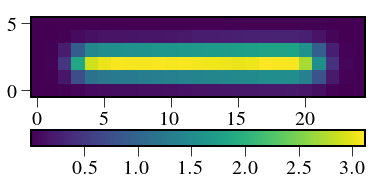

In [4]:
plt.imshow(subim)
plt.colorbar(orientation='horizontal')

In [5]:
print np.sum(subim)

119.967


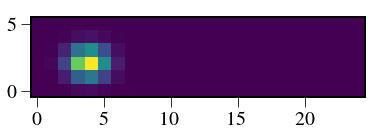

In [6]:
plt.imshow(psflet_subarr[0])
for i in range(psflet_subarr.shape[0]):
    psflet_subarr[i] /= np.sum(psflet_subarr[i])

In [7]:
print 1./np.sum(psflet_subarr[0]**2)

9.63189459363


10.0


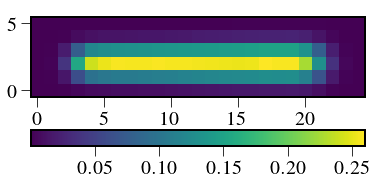

In [8]:
subim = np.sum(psflet_subarr,axis=0)
plt.imshow(subim)
plt.colorbar(orientation='horizontal')
print np.sum(subim)

0.19446558720480406

In [176]:
Nelec = 1000
poisson = np.random.poisson(subim*Nelec)

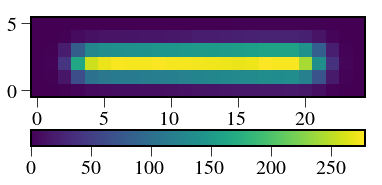

In [183]:
plt.imshow(poisson)
plt.colorbar(orientation='horizontal')
plt.imshow(subim*Nelec)

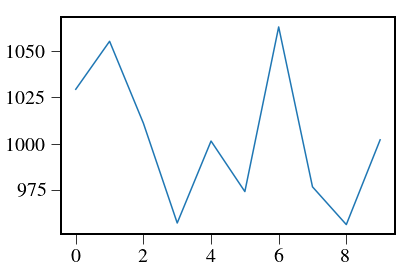

In [177]:
from crispy.IFS import reduceIFSMap
subim_flat = np.reshape(poisson, -1)
psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
coef = np.linalg.lstsq(psflets_flat.T, subim_flat)[0]
plt.plot(coef)

In [163]:
sumpsflets = np.reshape(subim*Nelec,-1)
x = subim_flat
A = psflets_flat.T
right = np.dot(np.transpose(A),x)
Cinv = np.dot(np.transpose(A),A)
C = np.linalg.inv(Cinv)
coefs2 = np.dot(left,right)
print coefs2
print coef
import pandas as pd
df = pd.DataFrame(data=Cinv)
df

[ 1029.07494861   879.24787784  1033.37495909  1000.32638945  1011.97641341
  1087.82293205   897.36978627  1060.88131053  1016.17029911   975.87481607]
[ 1029.07494861   879.24787784  1033.37495909  1000.32638945  1011.97641341
  1087.82293205   897.36978627  1060.88131053  1016.17029911   975.87481607]


,0,1,2,3,4,5,6,7,8,9
0,1.038217e-01,3.781686e-02,1.840839e-03,1.013038e-05,8.652204e-09,4.499302e-08,2.484550e-07,2.281947e-07,8.982292e-08,2.520272e-07
1,3.781686e-02,1.018298e-01,3.907701e-02,2.134296e-03,1.585353e-05,2.551539e-08,6.033666e-08,2.579995e-07,3.781318e-07,1.250960e-07
2,1.840839e-03,3.907701e-02,9.909606e-02,4.004341e-02,2.592649e-03,2.970352e-05,5.567989e-08,4.694419e-08,3.752633e-07,5.447811e-07
3,1.013038e-05,2.134296e-03,4.004341e-02,9.722045e-02,4.058052e-02,3.158885e-03,4.540734e-05,1.168523e-07,5.635559e-08,4.599480e-07
4,8.652204e-09,1.585353e-05,2.592649e-03,4.058052e-02,9.465773e-02,4.112732e-02,3.674209e-03,6.368950e-05,2.097110e-07,7.582652e-08
5,4.499302e-08,2.551539e-08,2.970352e-05,3.158885e-03,4.112732e-02,9.028060e-02,4.157850e-02,4.249863e-03,9.927493e-05,4.333803e-07
6,2.484550e-07,6.033666e-08,5.567989e-08,4.540734e-05,3.674209e-03,4.157850e-02,8.755923e-02,4.206276e-02,4.888705e-03,1.282256e-04
7,2.281947e-07,2.579995e-07,4.694419e-08,1.168523e-07,6.368950e-05,4.249863e-03,4.206276e-02,8.837557e-02,4.320411e-02,5.265365e-03
8,8.982292e-08,3.781318e-07,3.752633e-07,5.635559e-08,2.097110e-07,9.927493e-05,4.888705e-03,4.320411e-02,8.554713e-02,4.410052e-02
9,2.520272e-07,1.250960e-07,5.447811e-07,4.599480e-07,7.582652e-08,4.333803e-07,1.282256e-04,5.265365e-03,4.410052e-02,8.414933e-02


In [187]:
print np.reshape(subim*Nelec,-1)
print subim_flat

[  8.36914584e-03   9.71942144e-02   1.24568967e+00   4.85315231e+00
   7.82761818e+00   8.78953079e+00   9.22344047e+00   9.75942182e+00
   1.03366595e+01   1.09537093e+01   1.17170004e+01   1.25887064e+01
   1.35931775e+01   1.47113787e+01   1.58049908e+01   1.67012367e+01
   1.71757125e+01   1.75870260e+01   1.80836216e+01   1.85913175e+01
   1.70223436e+01   1.03571405e+01   3.03675836e+00   3.48716876e-01
   1.56939391e-02   1.85383312e-02   1.11728846e+00   1.57654281e+01
   6.18381017e+01   9.67073310e+01   1.03351188e+02   1.06288370e+02
   1.07457127e+02   1.09200287e+02   1.11509701e+02   1.12948176e+02
   1.15380036e+02   1.17349923e+02   1.19332164e+02   1.21273726e+02
   1.22778742e+02   1.24271421e+02   1.27199067e+02   1.27159103e+02
   1.28022613e+02   1.13592655e+02   6.62721778e+01   1.90021625e+01
   2.15541932e+00   8.66642450e-02   4.64581259e-02   2.80660223e+00
   3.96828873e+01   1.55726811e+02   2.41016863e+02   2.52896074e+02
   2.57951116e+02   2.56449351e+02

[ 1009.69949343  1082.5808662   1004.90373994   947.97632249   977.80226055
  1004.96213425  1045.63562269   996.39692379   957.57649455  1021.46614213]
[ 1029.41823826  1055.36635742  1011.03572279   957.09061157  1001.41691338
   974.09039007  1063.13357213   976.65161888   956.23135385  1002.07668355]


,0,1,2,3,4,5,6,7,8,9
0,7.734472e-04,2.157569e-04,1.015925e-05,5.566459e-08,2.388645e-09,3.760930e-08,1.326292e-07,1.090138e-07,5.624654e-08,2.430884e-07
1,2.157569e-04,5.585638e-04,2.135959e-04,1.162064e-05,8.647409e-08,1.094544e-09,2.859788e-08,1.174503e-07,1.509469e-07,7.810491e-08
2,1.015925e-05,2.135959e-04,5.433293e-04,2.181984e-04,1.415082e-05,1.644270e-07,1.144279e-09,2.049863e-08,1.491961e-07,2.309696e-07
3,5.566459e-08,1.162064e-05,2.181984e-04,5.302746e-04,2.218581e-04,1.743905e-05,2.507104e-07,1.135271e-09,2.505959e-08,2.765784e-07
4,2.388645e-09,8.647409e-08,1.415082e-05,2.218581e-04,5.168332e-04,2.264001e-04,2.023953e-05,3.500155e-07,2.217204e-09,7.705220e-08
5,3.760930e-08,1.094544e-09,1.644270e-07,1.743905e-05,2.264001e-04,5.006253e-04,2.311844e-04,2.358952e-05,5.499433e-07,8.529147e-09
6,1.326292e-07,2.859788e-08,1.144279e-09,2.507104e-07,2.023953e-05,2.311844e-04,4.880761e-04,2.324718e-04,2.691534e-05,6.998262e-07
7,1.090138e-07,1.174503e-07,2.049863e-08,1.135271e-09,3.500155e-07,2.358952e-05,2.324718e-04,4.795250e-04,2.350915e-04,2.872404e-05
8,5.624654e-08,1.509469e-07,1.491961e-07,2.505959e-08,2.217204e-09,5.499433e-07,2.691534e-05,2.350915e-04,4.743217e-04,2.627378e-04
9,2.430884e-07,7.810491e-08,2.309696e-07,2.765784e-07,7.705220e-08,8.529147e-09,6.998262e-07,2.872404e-05,2.627378e-04,7.069240e-04


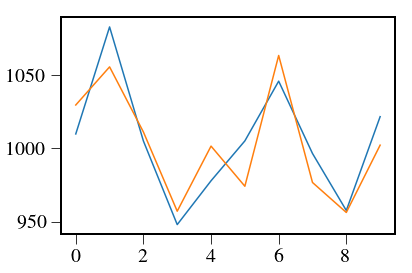

In [194]:
sumpsflets = np.reshape(subim*Nelec,-1)
x = subim_flat
A = psflets_flat.T
Ninv = np.linalg.inv(np.diag(sumpsflets))
right = np.dot(np.transpose(A),np.dot(Ninv,x))
Cinv = np.dot(np.transpose(A),np.dot(Ninv,A))
C = np.linalg.inv(Cinv)
coefs2 = np.dot(C,right)
print coefs2
print coef
plt.plot(coefs2)
plt.plot(coef)
import pandas as pd
df = pd.DataFrame(data=Cinv)
df


In [195]:
import scipy as sp
Q = sp.linalg.sqrtm(Cinv)
df = pd.DataFrame(data=Q)
df

,0,1,2,3,4,5,6,7,8,9
0,2.747264e-02,4.318693e-03,-2.179829e-04,0.000050,-0.000013,0.000005,0.000001,2.277440e-06,1.163512e-08,4.542546e-06
1,4.318693e-03,2.273227e-02,4.802638e-03,-0.000293,0.000072,-0.000020,0.000007,-1.299198e-07,3.622440e-06,3.294230e-07
2,-2.179829e-04,4.802638e-03,2.224853e-02,0.005013,-0.000289,0.000076,-0.000023,7.413944e-06,2.079646e-07,4.499250e-06
3,5.032201e-05,-2.926043e-04,5.012935e-03,0.021864,0.005189,-0.000267,0.000080,-2.426958e-05,7.348341e-06,3.478876e-06
4,-1.339374e-05,7.154025e-05,-2.888467e-04,0.005189,0.021460,0.005405,-0.000264,8.161484e-05,-2.441367e-05,6.603404e-06
5,4.591565e-06,-2.032603e-05,7.625768e-05,-0.000267,0.005405,0.020965,0.005634,-2.346800e-04,7.725068e-05,-1.681522e-05
6,1.077780e-06,6.741974e-06,-2.287725e-05,0.000080,-0.000264,0.005634,0.020572,5.746442e-03,-1.822801e-04,5.266418e-05
7,2.277440e-06,-1.299198e-07,7.413944e-06,-0.000024,0.000082,-0.000235,0.005746,2.030361e-02,5.847476e-03,-1.069790e-04
8,1.163512e-08,3.622440e-06,2.079646e-07,0.000007,-0.000024,0.000077,-0.000182,5.847476e-03,2.018732e-02,5.706236e-03
9,4.542546e-06,3.294230e-07,4.499250e-06,0.000003,0.000007,-0.000017,0.000053,-1.069790e-04,5.706236e-03,2.596822e-02


In [274]:
np.sum(Q[0])

0.031622776601683916

In [276]:
s = np.sum(Q,axis=1)
print s
R = Q/s[np.newaxis,:]
Ctilde_inv = np.diag(s**2)
Ctilde = np.dot(np.dot(R,C),R.T)
# eigvec,R = np.linalg.eig(Cinv)
# print eigvec
# Ctildeinv = np.diag(eigvec)
# Cinv_check = np.dot(R,np.dot(Ctildeinv,R.T))
# Ctilde = np.linalg.inv(Ctildeinv)
# pd.DataFrame(data=Cinv_check)
print np.sum(np.dot(R.T,R)[1])
print np.linalg.norm(coefs2)
print np.linalg.norm(np.dot(R.T,coefs2))
pd.DataFrame(data=R)




[ 0.03162278  0.03162278  0.03162278  0.03162278  0.03162278  0.03162278
  0.03162278  0.03162278  0.03162278  0.03162278]
1.0
3180.01850514
3178.99792594


,0,1,2,3,4,5,6,7,8,9
0,8.687611e-01,0.136569,-0.006893,0.001591,-0.000424,0.000145,0.000034,0.000072,3.679347e-07,0.000144
1,1.365691e-01,0.718858,0.151873,-0.009253,0.002262,-0.000643,0.000213,-0.000004,1.145516e-04,0.000010
2,-6.893223e-03,0.151873,0.703560,0.158523,-0.009134,0.002411,-0.000723,0.000234,6.576418e-06,0.000142
3,1.591322e-03,-0.009253,0.158523,0.691416,0.164080,-0.008455,0.002523,-0.000767,2.323749e-04,0.000110
4,-4.235471e-04,0.002262,-0.009134,0.164080,0.678622,0.170932,-0.008356,0.002581,-7.720279e-04,0.000209
5,1.451980e-04,-0.000643,0.002411,-0.008455,0.170932,0.662972,0.178148,-0.007421,2.442881e-03,-0.000532
6,3.408239e-05,0.000213,-0.000723,0.002523,-0.008356,0.178148,0.650542,0.181718,-5.764203e-03,0.001665
7,7.201898e-05,-0.000004,0.000234,-0.000767,0.002581,-0.007421,0.181718,0.642057,1.849134e-01,-0.003383
8,3.679347e-07,0.000115,0.000007,0.000232,-0.000772,0.002443,-0.005764,0.184913,6.383790e-01,0.180447
9,1.436479e-04,0.000010,0.000142,0.000110,0.000209,-0.000532,0.001665,-0.003383,1.804470e-01,0.821187


In [197]:
pd.DataFrame(data=Cinv)

,0,1,2,3,4,5,6,7,8,9
0,7.734472e-04,2.157569e-04,1.015925e-05,5.566459e-08,2.388645e-09,3.760930e-08,1.326292e-07,1.090138e-07,5.624654e-08,2.430884e-07
1,2.157569e-04,5.585638e-04,2.135959e-04,1.162064e-05,8.647409e-08,1.094544e-09,2.859788e-08,1.174503e-07,1.509469e-07,7.810491e-08
2,1.015925e-05,2.135959e-04,5.433293e-04,2.181984e-04,1.415082e-05,1.644270e-07,1.144279e-09,2.049863e-08,1.491961e-07,2.309696e-07
3,5.566459e-08,1.162064e-05,2.181984e-04,5.302746e-04,2.218581e-04,1.743905e-05,2.507104e-07,1.135271e-09,2.505959e-08,2.765784e-07
4,2.388645e-09,8.647409e-08,1.415082e-05,2.218581e-04,5.168332e-04,2.264001e-04,2.023953e-05,3.500155e-07,2.217204e-09,7.705220e-08
5,3.760930e-08,1.094544e-09,1.644270e-07,1.743905e-05,2.264001e-04,5.006253e-04,2.311844e-04,2.358952e-05,5.499433e-07,8.529147e-09
6,1.326292e-07,2.859788e-08,1.144279e-09,2.507104e-07,2.023953e-05,2.311844e-04,4.880761e-04,2.324718e-04,2.691534e-05,6.998262e-07
7,1.090138e-07,1.174503e-07,2.049863e-08,1.135271e-09,3.500155e-07,2.358952e-05,2.324718e-04,4.795250e-04,2.350915e-04,2.872404e-05
8,5.624654e-08,1.509469e-07,1.491961e-07,2.505959e-08,2.217204e-09,5.499433e-07,2.691534e-05,2.350915e-04,4.743217e-04,2.627378e-04
9,2.430884e-07,7.810491e-08,2.309696e-07,2.765784e-07,7.705220e-08,8.529147e-09,6.998262e-07,2.872404e-05,2.627378e-04,7.069240e-04


In [198]:
pd.DataFrame(data=Ctilde)

,0,1,2,3,4,5,6,7,8,9
0,1.000000e+03,1.084007e-12,1.566886e-12,1.973644e-12,4.704766e-13,4.424441e-13,2.410884e-13,2.062135e-13,-4.402034e-13,4.405920e-13
1,1.193874e-12,1.000000e+03,4.465956e-13,-4.328951e-13,1.238365e-12,3.927543e-13,-2.459259e-13,9.425893e-13,1.362799e-12,5.048739e-13
2,1.614585e-12,3.954041e-13,1.000000e+03,-3.943976e-14,7.756921e-15,-3.256844e-13,8.850875e-13,-8.340411e-14,3.250733e-13,5.933032e-13
3,1.980524e-12,-4.376654e-13,-9.869702e-14,1.000000e+03,-5.522832e-13,7.454553e-13,7.034309e-13,5.352422e-13,2.042810e-14,4.836131e-13
4,4.743130e-13,1.237227e-12,-1.214769e-13,-6.334758e-13,1.000000e+03,1.993751e-12,-4.876598e-13,2.353952e-12,1.215028e-12,1.912248e-12
5,4.438471e-13,4.027736e-13,-2.712018e-13,7.028230e-13,1.971726e-12,1.000000e+03,-1.748890e-14,7.322187e-13,2.842171e-13,-9.237056e-14
6,2.416984e-13,-2.363970e-13,8.816225e-13,6.891675e-13,-4.950891e-13,-1.384378e-13,1.000000e+03,-4.588506e-13,-3.126388e-13,-6.181722e-13
7,2.053900e-13,9.448034e-13,-8.125549e-14,5.560882e-13,2.358866e-12,8.205061e-13,-3.870634e-13,1.000000e+03,3.410605e-13,-4.263256e-13
8,-4.401859e-13,1.362754e-12,3.309383e-13,2.070794e-14,1.254560e-12,2.071758e-13,-3.130328e-13,3.154448e-13,1.000000e+03,4.547474e-13
9,4.407484e-13,5.047325e-13,5.944053e-13,4.857925e-13,1.920158e-12,-9.832259e-14,-5.997332e-13,-5.061070e-13,3.410605e-13,1.000000e+03


In [199]:
pd.DataFrame(data=R)

,0,1,2,3,4,5,6,7,8,9
0,8.687611e-01,0.136569,-0.006893,0.001591,-0.000424,0.000145,0.000034,0.000072,3.679347e-07,0.000144
1,1.365691e-01,0.718858,0.151873,-0.009253,0.002262,-0.000643,0.000213,-0.000004,1.145516e-04,0.000010
2,-6.893223e-03,0.151873,0.703560,0.158523,-0.009134,0.002411,-0.000723,0.000234,6.576418e-06,0.000142
3,1.591322e-03,-0.009253,0.158523,0.691416,0.164080,-0.008455,0.002523,-0.000767,2.323749e-04,0.000110
4,-4.235471e-04,0.002262,-0.009134,0.164080,0.678622,0.170932,-0.008356,0.002581,-7.720279e-04,0.000209
5,1.451980e-04,-0.000643,0.002411,-0.008455,0.170932,0.662972,0.178148,-0.007421,2.442881e-03,-0.000532
6,3.408239e-05,0.000213,-0.000723,0.002523,-0.008356,0.178148,0.650542,0.181718,-5.764203e-03,0.001665
7,7.201898e-05,-0.000004,0.000234,-0.000767,0.002581,-0.007421,0.181718,0.642057,1.849134e-01,-0.003383
8,3.679347e-07,0.000115,0.000007,0.000232,-0.000772,0.002443,-0.005764,0.184913,6.383790e-01,0.180447
9,1.436479e-04,0.000010,0.000142,0.000110,0.000209,-0.000532,0.001665,-0.003383,1.804470e-01,0.821187


In [200]:
ftilde = np.dot(R.T,coefs2)

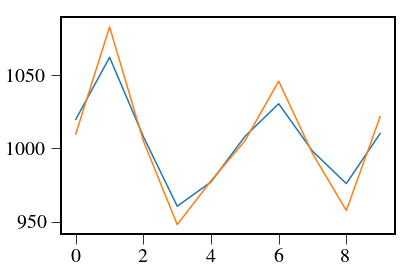

In [201]:
plt.plot(ftilde)
plt.plot(coefs2)

6158.30269334


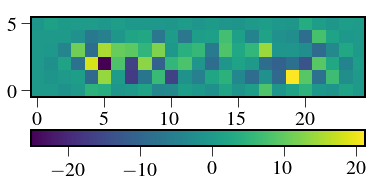

In [202]:
res = poisson-np.reshape(np.dot(A,ftilde),subim.shape)
plt.imshow(res)
plt.colorbar(orientation='horizontal')
print np.sum(res**2)

5983.40627738


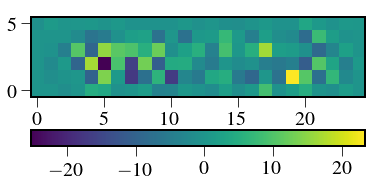

In [205]:
res = poisson-np.reshape(np.dot(A,coef),subim.shape)
plt.imshow(res)
plt.colorbar(orientation='horizontal')
print np.sum(res**2)

In [79]:
pd.DataFrame(data=Ctilde)

,0,1,2,3,4,5,6,7,8,9
0,1.000000e+03,1.047164e-12,1.542670e-12,1.991906e-12,4.865038e-13,4.442494e-13,2.420484e-13,2.050090e-13,-4.404810e-13,4.401479e-13
1,1.183358e-12,1.000000e+03,3.873132e-13,-4.613495e-13,1.164422e-12,3.901602e-13,-2.500752e-13,9.494771e-13,1.362466e-12,5.052070e-13
2,1.591648e-12,3.043960e-13,1.000000e+03,6.667713e-14,2.702058e-13,-3.383922e-13,8.948923e-13,-9.800312e-14,3.308465e-13,5.939693e-13
3,1.999778e-12,-4.935485e-13,-5.824559e-14,1.000000e+03,-6.077263e-13,4.119348e-13,7.892916e-13,5.280457e-13,3.641532e-14,4.818368e-13
4,4.862728e-13,1.164545e-12,1.641657e-13,-7.136695e-13,1.000000e+03,1.764369e-12,-3.280897e-13,2.212372e-12,1.261213e-12,1.908695e-12
5,4.475986e-13,4.012577e-13,-2.678575e-13,3.837688e-13,1.915488e-12,1.000000e+03,1.867192e-13,9.082254e-13,3.268497e-13,-1.154632e-13
6,2.419082e-13,-2.423133e-13,8.931239e-13,7.634229e-13,-2.714065e-13,7.857264e-14,1.000000e+03,-4.708012e-13,-4.831691e-13,-5.329071e-13
7,2.044334e-13,9.502762e-13,-9.851634e-14,5.561742e-13,2.221975e-12,9.333929e-13,-3.687920e-13,1.000000e+03,2.842171e-13,-4.973799e-13
8,-4.399681e-13,1.360916e-12,3.353250e-13,3.126327e-14,1.292535e-12,2.305231e-13,-4.308748e-13,3.055963e-13,1.000000e+03,5.115908e-13
9,4.407388e-13,5.050290e-13,5.937839e-13,4.820915e-13,1.916001e-12,-1.087304e-13,-5.294150e-13,-5.481175e-13,3.979039e-13,1.000000e+03


In [78]:
pd.DataFrame(data=np.dot(R.T,np.dot(Ctilde_inv,R)))

,0,1,2,3,4,5,6,7,8,9
0,7.734472e-04,2.157569e-04,1.015925e-05,5.566459e-08,2.388645e-09,3.760930e-08,1.326292e-07,1.090138e-07,5.624654e-08,2.430884e-07
1,2.157569e-04,5.585638e-04,2.135959e-04,1.162064e-05,8.647409e-08,1.094544e-09,2.859788e-08,1.174503e-07,1.509469e-07,7.810491e-08
2,1.015925e-05,2.135959e-04,5.433293e-04,2.181984e-04,1.415082e-05,1.644270e-07,1.144279e-09,2.049863e-08,1.491961e-07,2.309696e-07
3,5.566459e-08,1.162064e-05,2.181984e-04,5.302746e-04,2.218581e-04,1.743905e-05,2.507104e-07,1.135271e-09,2.505959e-08,2.765784e-07
4,2.388645e-09,8.647409e-08,1.415082e-05,2.218581e-04,5.168332e-04,2.264001e-04,2.023953e-05,3.500155e-07,2.217204e-09,7.705220e-08
5,3.760930e-08,1.094544e-09,1.644270e-07,1.743905e-05,2.264001e-04,5.006253e-04,2.311844e-04,2.358952e-05,5.499433e-07,8.529147e-09
6,1.326292e-07,2.859788e-08,1.144279e-09,2.507104e-07,2.023953e-05,2.311844e-04,4.880761e-04,2.324718e-04,2.691534e-05,6.998262e-07
7,1.090138e-07,1.174503e-07,2.049863e-08,1.135271e-09,3.500155e-07,2.358952e-05,2.324718e-04,4.795250e-04,2.350915e-04,2.872404e-05
8,5.624654e-08,1.509469e-07,1.491961e-07,2.505959e-08,2.217204e-09,5.499433e-07,2.691534e-05,2.350915e-04,4.743217e-04,2.627378e-04
9,2.430884e-07,7.810491e-08,2.309696e-07,2.765784e-07,7.705220e-08,8.529147e-09,6.998262e-07,2.872404e-05,2.627378e-04,7.069240e-04


Expected SNR: 31.6227766017
Estimated SNR: 30.9676343937
Mean: 999.641133786
Std: 32.280190378


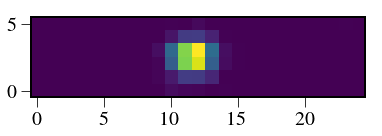

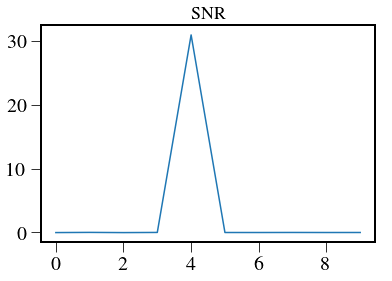

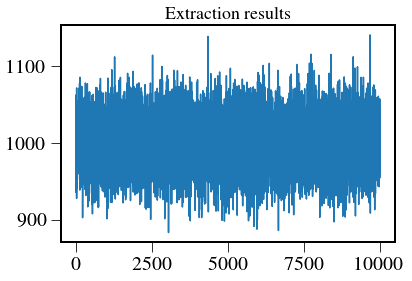

In [98]:
subim = psflet_subarr[4]#np.sum(psflet_subarr,axis=0)
# subim = np.sum(psflet_subarr,axis=0)
sumpsflets = subim+1e-10
Nelec = 1000
Niter = 10000
vals = np.zeros((10,Niter))
for i in range(Niter):
    poisson = np.random.poisson(subim*Nelec)
    subim_flat = np.reshape(poisson/np.sqrt(sumpsflets), -1)
    psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
    sumpsflets_flat = np.reshape(sumpsflets,-1)
    vals[:,i] = np.linalg.lstsq(psflets_flat.T/(np.sqrt(sumpsflets_flat[:,np.newaxis])), subim_flat)[0]
estSNR = np.mean(vals,axis=1)/np.std(vals,axis=1)
plt.figure()
plt.imshow(poisson)
plt.figure()
plt.plot(estSNR)
plt.title('SNR')
print "Expected SNR:",np.sqrt(Nelec)
print "Estimated SNR:",estSNR[4]

plt.figure()
plt.plot(vals[4])
plt.title('Extraction results')

print 'Mean:',np.mean(vals[4])
print 'Std:',np.std(vals[4])

In [76]:
subim[np.newaxis,:].shape
psflets_flat.T.shape

(150, 10)

In [277]:
# subim = psflet_subarr[3]+psflet_subarr[4]+psflet_subarr[5]
# sumpsflets = psflet_subarr[3]+psflet_subarr[4]+psflet_subarr[5]+1e-10
def calcSNR(Nelec,subim,psflet_subarr,pixnoise=0,npix=0,Niter=10000,plot=True):
    #sumpsflets = subim*Nelec+pixnoise+1e-10
    vals = np.zeros((10,Niter))
    for i in range(Niter):
        # subtract mean of background (assumed known)
        img = np.random.poisson(subim*Nelec)+np.random.poisson(pixnoise,subim.shape)-pixnoise
#         subim_flat = np.reshape(img/np.sqrt(sumpsflets), -1)
#         psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
#         sumpsflets_flat = np.reshape(sumpsflets,-1)
#         vals[:,i] = np.linalg.lstsq(psflets_flat.T/(np.sqrt(sumpsflets_flat[:,np.newaxis])), subim_flat)[0]
        x = np.reshape(img,-1)
        psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
        variance = np.reshape(img+pixnoise+1,-1)
        A = psflets_flat.T
        Ninv = np.linalg.inv(np.diag(variance))
        right = np.dot(np.transpose(A),np.dot(Ninv,x))
        Cinv = np.dot(np.transpose(A),np.dot(Ninv,A))
        C = np.linalg.inv(Cinv)
        f = np.dot(C,right)
        Q = sp.linalg.sqrtm(Cinv)
        s = np.sum(Q,axis=1)
        R = Q/s[np.newaxis,:]
        Ctilde_inv = np.diag(s**2)
        Ctilde = np.dot(np.dot(R,C),R.T)
        vals[:,i] = np.dot(R,f)

    estSNR = np.mean(vals,axis=1)/np.std(vals,axis=1)
    if plot:
        plt.figure()
        plt.imshow(img)
        plt.colorbar(orientation='horizontal')
        plt.figure()
        plt.plot(estSNR)
        plt.title('SNR')
        SNR = Nelec/(np.sqrt(Nelec+npix*pixnoise))
        print "Expected SNR:",SNR
        print "Estimated SNR:",estSNR[4]
        print "Change:",100*(SNR-estSNR[4])/SNR,"%"

        plt.figure()
        plt.plot(vals[4])
        plt.title('Extraction results')

        print 'Mean:',np.mean(vals[4])
        print 'Std:',np.std(vals[4])
    return estSNR,vals

In [156]:
Nelec = 1000

Expected SNR: 31.6227766017
Estimated SNR: 30.7577016161
Change: 2.7356073013 %
Mean: 796.608025005
Std: 25.899465277


array([  2.57132442e-02,   1.10545907e-02,   4.42679633e-01,
         2.30761283e+01,   3.07577016e+01,   2.69894946e+01,
         3.18068080e-01,  -1.43264083e-02,   1.21083747e-02,
         4.26662721e-03])

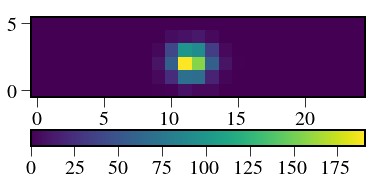

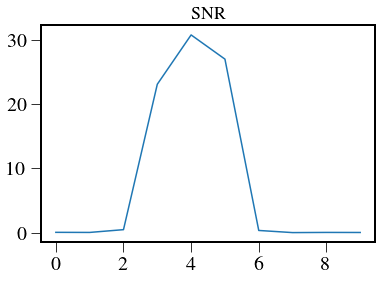

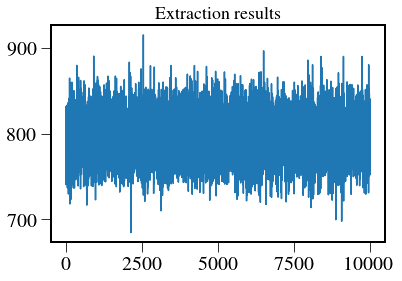

In [97]:
subim = psflet_subarr[4]
calcSNR(Nelec=Nelec,
        subim=subim,
        psflet_subarr=psflet_subarr,
        pixnoise=0,
        npix=0,
        plot=True)


Expected SNR: 31.6227766017
Estimated SNR: 30.2364911003
Change: 4.38381967158 %
Mean: 965.720605249
Std: 31.938911233


array([  4.41647161e-03,   3.61707089e-01,   2.22621102e+01,
         3.20128514e+01,   3.02364911e+01,   3.19807643e+01,
         2.30514677e+01,   8.38364765e-01,  -1.40290249e-02,
         3.04891060e-02])

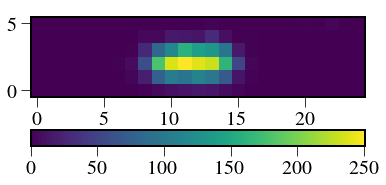

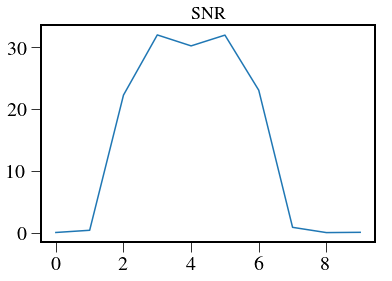

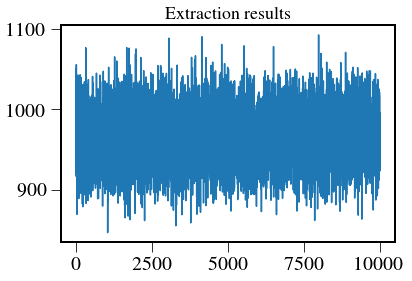

In [98]:
subim = psflet_subarr[3]+psflet_subarr[4]+psflet_subarr[5]
calcSNR(Nelec=Nelec,
        subim=subim,
        psflet_subarr=psflet_subarr,
        pixnoise=0,
        npix=0,
        plot=True)


Expected SNR: 10.0
Estimated SNR: 9.98081149587
Change: 0.191885041347 %
Mean: 93.9804129338
Std: 9.41610939879


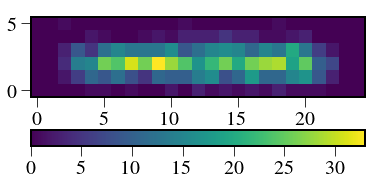

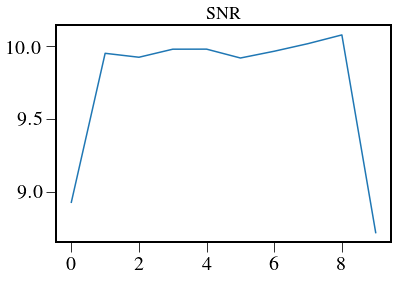

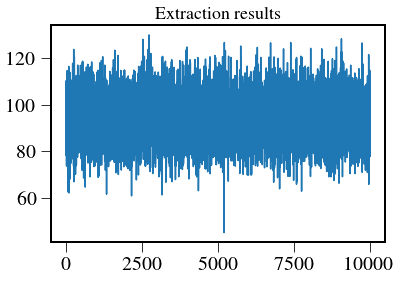

In [279]:
subim = np.sum(psflet_subarr,axis=0)
est,vals = calcSNR(Nelec=100,
        subim=subim,
        psflet_subarr=psflet_subarr,
        pixnoise=0,
        npix=0,
        plot=True)



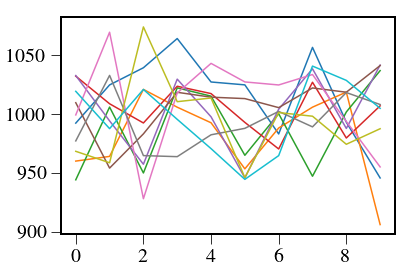

In [207]:
plt.plot(vals[:,500:510])

Expected SNR: 9.53462589246
Estimated SNR: 6.88169078276
Change: 27.8242181667 %
Mean: 1000.24890453
Std: 145.349295124


array([ -1.16564273e-02,   9.98796925e-03,  -1.34675929e-02,
        -1.03571127e-02,   6.88169078e+00,   1.23015588e-02,
         3.05834008e-03,  -8.97785608e-03,   1.35429766e-02,
        -1.03598799e-02])

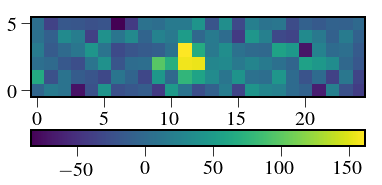

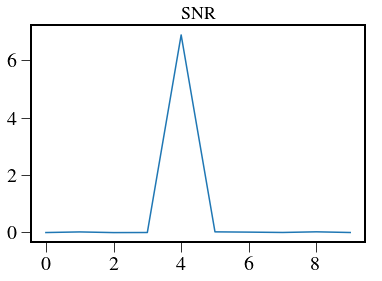

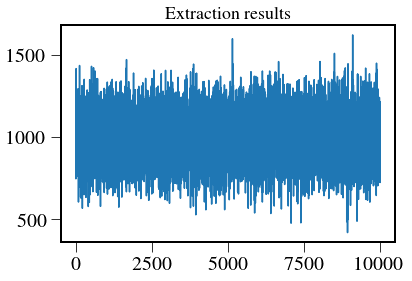

In [172]:
subim = psflet_subarr[4]
calcSNR(Nelec=Nelec,
        subim=subim,
        psflet_subarr=psflet_subarr,
        pixnoise=1000,
        npix=10,
        plot=True)


This is the main function that suggests that an npix of ~6 is appropriate for the regime we are in (<1000 electrons)

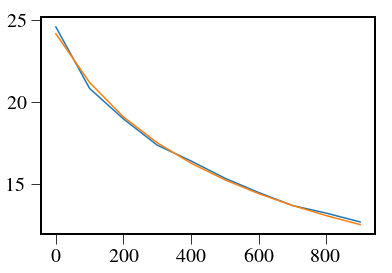

In [208]:
noiselist = np.arange(0,1000,100)  # mean number of electrons from background
estvals = []
compvals = []
npix = 6
Nelec=2000
for val in noiselist:
#     subim = psflet_subarr[4]
    subim = np.sum(psflet_subarr,axis=0)
    estSNR = calcSNR(Nelec=Nelec,
        subim=subim,
        psflet_subarr=psflet_subarr,
        pixnoise=val,
        npix=npix,
        plot=False)
    estvals.append(estSNR[4])
    compvals.append(Nelec/(np.sqrt(Nelec+npix*val)))
plt.plot(noiselist,estvals)
plt.plot(noiselist,np.array(compvals)*0.54)

### Here we try to calculate the overlap fraction of two neighboring PSFs

In [188]:
np.sum(psflet_subarr[4]*psflet_subarr[5]+psflet_subarr[4]*psflet_subarr[3])

0.081430537510390921

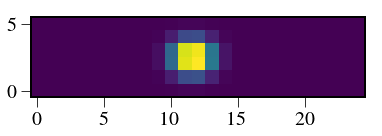

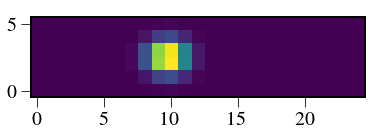

In [191]:
plt.figure()
plt.imshow(psflet_subarr[4])
plt.figure()

plt.imshow(psflet_subarr[3])


0.402294711401
0.810877565754


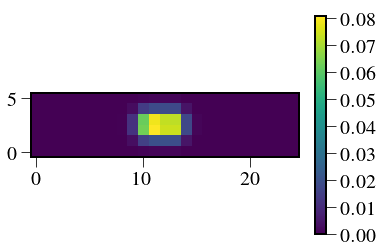

In [204]:
print np.sum(np.minimum(psflet_subarr[4],psflet_subarr[3])+np.minimum(psflet_subarr[4],psflet_subarr[6]))
val=0
img=np.zeros_like(subim)
for i in range(10):
    if i!=4:
        img += np.minimum(psflet_subarr[4],psflet_subarr[i])
        val+=np.sum(np.minimum(psflet_subarr[4],psflet_subarr[i]))
print val
plt.imshow(img)
plt.colorbar()


In [2]:
from crispy.unitTests import testOptExt
im = Image(filename = par.wavecalDir + 'polychromeR%dstack.fits' % (par.R))
spec,var = testOptExt(par,im,54,54,smoothandmask=False)

crispy - INFO - Read data from HDU 0 of ..//ReferenceFiles/wavecalR50_660/polychromeR50stack.fits
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - WARNING - No PSFLet widths found - assuming critical samping at central wavelength


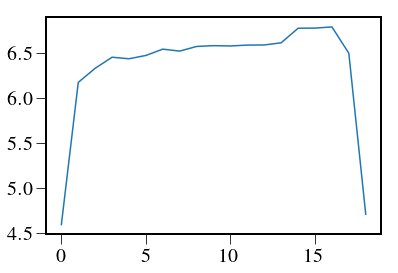

In [5]:
plt.plot(spec)

In [116]:
from crispy.tools.locate_psflets import PSFLets
PSFlet_tool = PSFLets(load=True, infiledir=par.wavecalDir)
i=54
j=54
xindx = PSFlet_tool.xindx
yindx = PSFlet_tool.yindx
Nmax = PSFlet_tool.nlam_max


_x = xindx[i, j, :PSFlet_tool.nlam[i, j]]
_y = yindx[i, j, :PSFlet_tool.nlam[i, j]]
_lam = PSFlet_tool.lam_indx[i, j, :PSFlet_tool.nlam[i, j]]
X = _x-y0
X = X[1:-1]
Y = _y-x0
Y = Y[1:-1]
lam = _lam[1:-1]
print X,Y,_lam

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.] [ 2.48430467  2.4846161   2.48488505  2.48511378  2.48530457  2.48545978
  2.48558134  2.48567283  2.4857371   2.48577668  2.48579567  2.48579714
  2.48578521  2.48576374  2.48573718  2.48571006  2.48568725  2.48567393
  2.48567578  2.48569841  2.485748    2.48583112  2.48595499  2.48612681
  2.48635425  2.48664551] [ 576.74744611  582.56776822  588.44268775  594.37264881  600.35835049
  606.40062819  612.50047722  618.66004432  624.87883289  631.15786097
  637.49968826  643.90332588  650.37139018  656.90367092  663.50229484
  670.16694683  676.90053916  683.70230327  690.57396904  697.51721008
  704.53206937  711.61970547  718.78123942  726.01815774  733.33105824
  740.72074028  748.18813204  755.7341012 ]


In [117]:
subim = np.sum(psflet_subarr,axis=0)
subim*=1000
spec = np.zeros(subim.shape[1])
subim_res = subim.copy()
sig = 2./2.35*lam/par.FWHMlam
y = np.mean(Y)                  
for i in range(subim.shape[1]):
    weights = np.exp(-(np.arange(subim.shape[0])-y)**2/2./sig[i]**2)/sig[i]/np.sqrt(2.*np.pi)
    spec[i] = np.sum(subim[:,i]*weights)/np.sum(weights**2)
    subim_res[:,i] -= spec[i]*weights
    print spec[i]

0.0446018525614
3.27742529873
57.1886856588
267.776676199
464.059651946
503.382148237
517.63097062
520.938413141
524.682808036
534.528985074
535.782353331
542.845373307
547.14135606
550.165539601
554.385271925
557.797197134
563.948038094
580.779276101
582.289961553
586.381659471
538.023559796
337.269050645
108.522932829
14.2039514417
0.670589282647


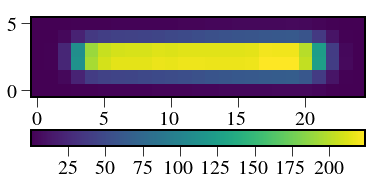

In [120]:
plt.imshow(subim)
plt.colorbar(orientation='horizontal')

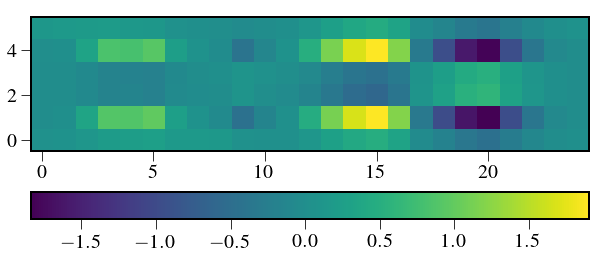

In [119]:
plt.figure(figsize=(10,5))
plt.imshow(subim_res)
plt.colorbar(orientation='horizontal')

In [200]:
from crispy.tools.locate_psflets import PSFLets

def calcSNROptExt(Nelec,subim,pixnoise=0,npix=0,Niter=10000,plot=True):
    PSFlet_tool = PSFLets(load=True, infiledir=par.wavecalDir)
    xindx = PSFlet_tool.xindx
    yindx = PSFlet_tool.yindx
    Nmax = PSFlet_tool.nlam_max

    i=lensX+54
    j=lensY+54
    _x = xindx[i, j, :PSFlet_tool.nlam[i, j]]
    _y = yindx[i, j, :PSFlet_tool.nlam[i, j]]
    _lam = PSFlet_tool.lam_indx[i, j, :PSFlet_tool.nlam[i, j]]
    X = _x-y0
    X = X[1:-1]
    Y = _y-x0
    Y = Y[1:-1]
    lam = _lam[1:-1]

    vals = np.zeros((subim.shape[1],Niter))
    for j in range(Niter):
        # subtract mean of background (assumed known)
        img = np.random.poisson(subim*Nelec)+np.random.poisson(pixnoise,subim.shape)-pixnoise
        spec = np.zeros(subim.shape[1])
        sig = 2./2.35*lam/par.FWHMlam
        y = np.mean(Y)                  
        for i in range(img.shape[1]):
            weights = np.exp(-(np.arange(img.shape[0])-y)**2/2./sig[i]**2)/sig[i]/np.sqrt(2.*np.pi)
            vals[i,j] = np.sum(img[:,i]*weights)/np.sum(weights**2)    
    estSNR = np.mean(vals,axis=1)/np.std(vals,axis=1)
    estSNR_central = np.mean(0.5*(vals[13,:]+vals[14,:]))/np.std(0.5*(vals[13,:]+vals[14,:]))
    if plot:
        plt.figure()
        plt.imshow(img)
        plt.colorbar(orientation='horizontal')
        plt.figure()
        plt.plot(estSNR)
        plt.title('SNR')
        SNR = Nelec/(np.sqrt(Nelec+npix*pixnoise))
        print "Expected SNR:",SNR
        print "Estimated SNR:",estSNR_central
        print "Change:",100*(SNR-estSNR_central)/SNR,"%"

        plt.figure()
        plt.plot(vals[4])
        plt.title('Extraction results')

        print 'Mean:',np.mean(0.5*(vals[13,:]+vals[14,:]))
        print 'Std:',np.std(0.5*(vals[13,:]+vals[14,:]))
    return estSNR_central

Expected SNR: 31.6227766017
Estimated SNR: 31.2107892037
Change: 1.30281854503 %
Mean: 549.900953784
Std: 17.6189378037


array([  0.27040382,   2.14276031,   8.13595503,  16.05282627,
        19.98479726,  20.46354341,  20.64617222,  20.76131422,
        21.20873272,  21.03647236,  21.63223922,  21.15233367,
        21.38052993,  21.92690443,  21.83935768,  22.18571597,
        21.91702882,  22.32115096,  22.01193149,  22.58144857,
        20.97975538,  16.01598351,   8.53553894,   2.89301963,   0.58626053])

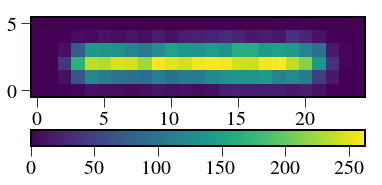

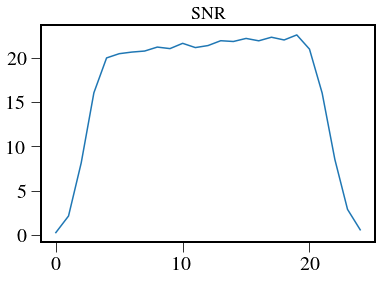

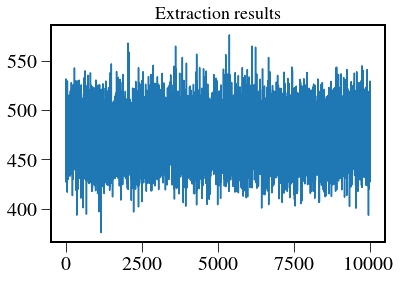

In [198]:
subim = np.sum(psflet_subarr,axis=0)
calcSNROptExt(Nelec=1000,
        subim=subim,
        pixnoise=0,
        npix=6,
        plot=True)

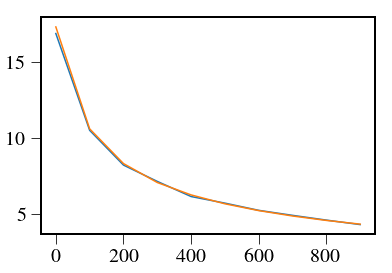

In [207]:
noiselist = np.arange(0,1000,100)  # mean number of electrons from background
estvals = []
compvals = []
npix = 5
Nelec=300
for val in noiselist:
#     subim = psflet_subarr[4]
    subim = np.sum(psflet_subarr,axis=0)
    estSNR = calcSNROptExt(Nelec=Nelec,
        subim=subim,
        pixnoise=val,
        npix=npix,
        plot=False)
    estvals.append(estSNR)
    compvals.append(Nelec/(np.sqrt(Nelec+npix*val)))
plt.figure(figsize=(10,8))
plt.title('Optimal extraction')
plt.plot(noiselist,estvals,label="Simulated")
plt.xlabel('Number of additive noise electrons per pixel')
plt.ylabel('SNR')
plt.plot(noiselist,np.array(compvals),label='Expected with npix=%d' % npix)
plt.legend()

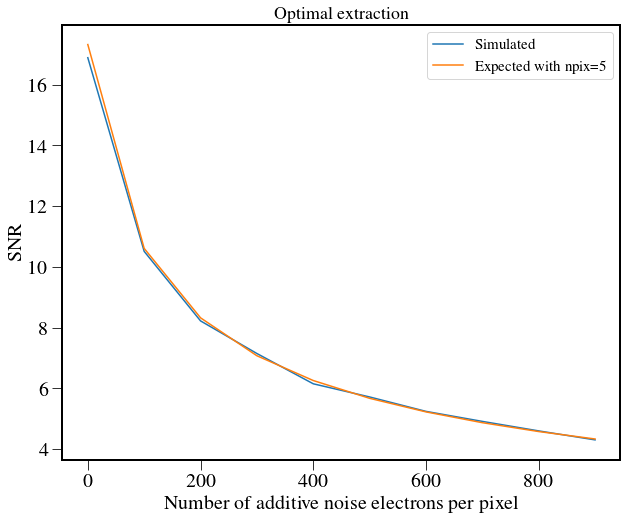

In [208]:
plt.figure(figsize=(10,8))
plt.title('Optimal extraction')
plt.plot(noiselist,estvals,label="Simulated")
plt.xlabel('Number of additive noise electrons per pixel')
plt.ylabel('SNR')
plt.plot(noiselist,np.array(compvals),label='Expected with npix=%d' % npix)
plt.legend()

## Test with Richardson-Lucy deconvolution

In [177]:
# subim = psflet_subarr[3]+psflet_subarr[4]+psflet_subarr[5]
# sumpsflets = psflet_subarr[3]+psflet_subarr[4]+psflet_subarr[5]+1e-10
from crispy.tools.reduction import RL
def calcSNR_RL(Nelec,subim,psflet_subarr,pixnoise=0,npix=0,Niter=10000,plot=True):
    sumpsflets = subim*Nelec+pixnoise+1e-10
    vals = np.zeros((10,Niter))
    for i in range(Niter):
        # subtract mean of background (assumed known)
        img = np.random.poisson(subim*Nelec)+np.random.poisson(pixnoise,subim.shape)-pixnoise
#         subim_flat = np.reshape(img/np.sqrt(sumpsflets), -1)
#         psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
#         sumpsflets_flat = np.reshape(sumpsflets,-1)
#         vals[:,i] = np.linalg.lstsq(psflets_flat.T/(np.sqrt(sumpsflets_flat[:,np.newaxis])), subim_flat)[0]
        vals[:,i] = RL(img,psflets=psflet_subarr)[0]
    estSNR = np.mean(vals,axis=1)/np.std(vals,axis=1)
    if plot:
        plt.figure()
        plt.imshow(img)
        plt.colorbar(orientation='horizontal')
        plt.figure()
        plt.plot(estSNR)
        plt.title('SNR')
        SNR = Nelec/(np.sqrt(Nelec+npix*pixnoise))
        print "Expected SNR:",SNR
        print "Estimated SNR:",estSNR[4]
        print "Change:",100*(SNR-estSNR[4])/SNR,"%"

        plt.figure()
        plt.plot(vals[4])
        plt.title('Extraction results')

        print 'Mean:',np.mean(vals[4])
        print 'Std:',np.std(vals[4])
    return estSNR

Expected SNR: 31.6227766017
Estimated SNR: 16.3542561444
Change: 48.2833011459 %
Mean: 1000.03944128
Std: 61.1485739525


array([ 25.29353844,  19.03189105,  17.99034366,  17.26681037,
        16.35425614,  15.38258849,  14.89139398,  14.27061078,
        14.59881942,  21.86956021])

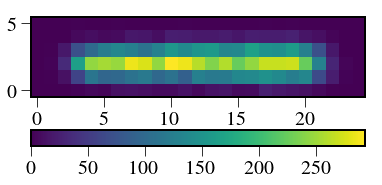

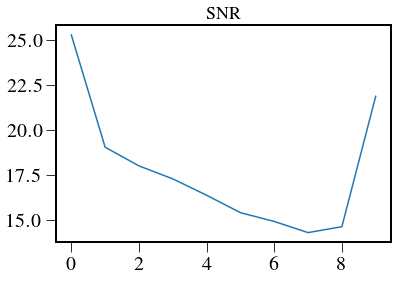

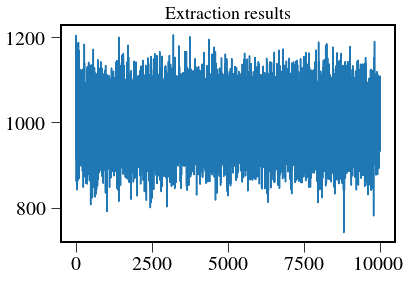

In [178]:
subim = np.sum(psflet_subarr,axis=0)
calcSNR_RL(Nelec=1000,
        subim=subim,
        psflet_subarr=psflet_subarr,
        pixnoise=0,
        npix=10,
        plot=True)

### Attempt truncating the PSFLet templates to only the brightest pixels

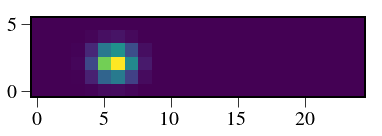

In [150]:
psflet_subarr.shape
psflet_subarr_trunc = psflet_subarr.copy()
for i in range(psflet_subarr.shape[0]):
    psflet_subarr_trunc[i][psflet_subarr_trunc[i]<0.0*np.amax(psflet_subarr_trunc[i])] = 0.0
plt.imshow(psflet_subarr_trunc[1])

Expected SNR: 31.6227766017
Estimated SNR: 16.2497674921
Change: 48.6137232767 %
Mean: 1000.11448588
Std: 61.54638744
Expected SNR: 31.6227766017
Estimated SNR: 17.0778868326
Change: 45.9949799862 %
Mean: 999.480937119
Std: 58.5248600669


array([ 25.93189601,  19.93480401,  18.74626713,  17.77729454,
        17.07788683,  16.15315762,  15.41766018,  14.98195899,
        15.69786372,  22.90833254])

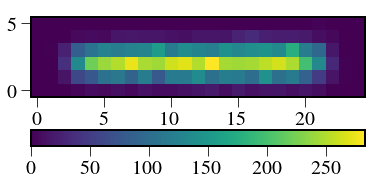

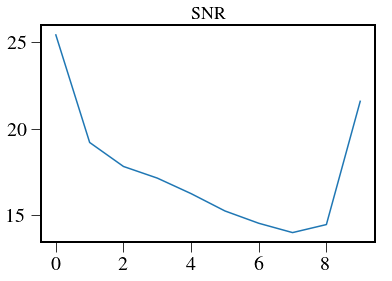

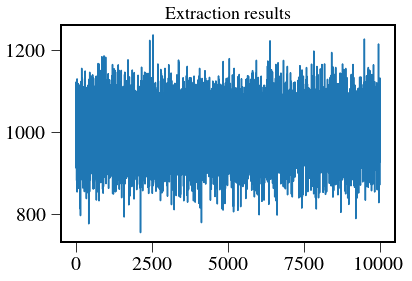

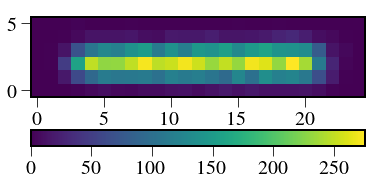

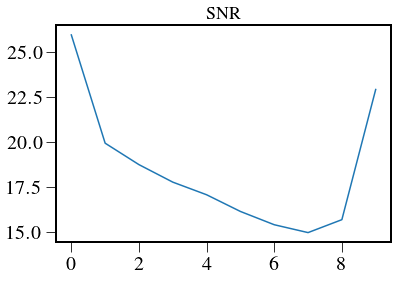

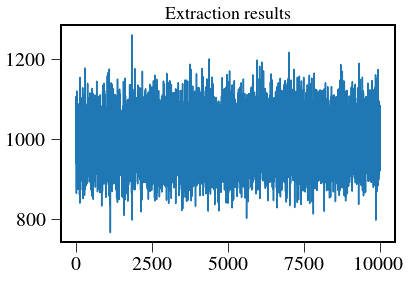

In [196]:
subim = np.sum(psflet_subarr,axis=0)
calcSNR_RL(Nelec=1000,
        subim=subim,
        psflet_subarr=psflet_subarr,
        pixnoise=0,
        npix=10,
        plot=True)
subim = np.sum(psflet_subarr,axis=0)
calcSNR(Nelec=1000,
        subim=subim,
        psflet_subarr=psflet_subarr,
        pixnoise=0,
        npix=10,
        plot=True)

In [269]:
from crispy.tools.reduction import RL
from crispy.tools.reduction import calculateWaveList
par.nchanperspec_lstsq = 1.
def calcSNRtotal(Nelec,subim,psflet_subarr,pixnoise=0,npix=0,Niter=10000,plot=True):
    #sumpsflets = subim*Nelec+pixnoise+1e-10
    lstsq = np.zeros((10,Niter))
    RLvals = np.zeros((10,Niter))
    optext = np.zeros((subim.shape[1],Niter))
    PSFlet_tool = PSFLets(load=True, infiledir=par.wavecalDir)
    xindx = PSFlet_tool.xindx
    yindx = PSFlet_tool.yindx
    Nmax = PSFlet_tool.nlam_max
    i=lensX+54
    j=lensY+54
    _x = xindx[i, j, :PSFlet_tool.nlam[i, j]]
    _y = yindx[i, j, :PSFlet_tool.nlam[i, j]]
    _lam = PSFlet_tool.lam_indx[i, j, :PSFlet_tool.nlam[i, j]]
    X = _x-y0
    X = X[1:-1]
    Y = _y-x0
    Y = Y[1:-1]
    lam = _lam[1:-1]

    psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
    variance = np.reshape(subim*Nelec+pixnoise+1e-10,-1)
    A = psflets_flat.T
    Ninv = np.linalg.inv(np.diag(variance))
    Cinv = np.dot(np.transpose(A),np.dot(Ninv,A))
    C = np.linalg.inv(Cinv)
    Q = sp.linalg.sqrtm(Cinv)
    s = np.sum(Q,axis=1)
    R = Q/s[np.newaxis,:]
    Ctilde_inv = np.diag(s**2)
    Ctilde = np.dot(np.dot(R,C),R.T)

    for j in range(Niter):
        # subtract mean of background (assumed known)
        img = np.random.poisson(subim*Nelec)+np.random.poisson(pixnoise,subim.shape)-pixnoise
#         subim_flat = np.reshape(img/np.sqrt(sumpsflets), -1)
#         psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
#         sumpsflets_flat = np.reshape(sumpsflets,-1)
#         vals[:,i] = np.linalg.lstsq(psflets_flat.T/(np.sqrt(sumpsflets_flat[:,np.newaxis])), subim_flat)[0]
        x = np.reshape(img,-1)
        right = np.dot(np.transpose(A),np.dot(Ninv,x))
        f = np.dot(C,right)
        lstsq[:,j] = np.dot(R,f)
        RLvals[:,j] = np.dot(R,RL(img,psflets=psflet_subarr)[0])
        
        

        spec = np.zeros(subim.shape[1])
        sig = 2./2.35*lam/par.FWHMlam
        y = np.mean(Y)                  
        for i in range(img.shape[1]):
            weights = np.exp(-(np.arange(img.shape[0])-y)**2/2./sig[i]**2)/sig[i]/np.sqrt(2.*np.pi)
            optext[i,j] = np.sum(img[:,i]*weights)/np.sum(weights**2)    


    estSNRlstsq = np.mean(lstsq,axis=1)/np.std(lstsq,axis=1)
    estSNRRL = np.mean(RLvals,axis=1)/np.std(RLvals,axis=1)
    estSNROptExt = np.mean(0.5*(optext[13,:]+optext[14,:]))/np.std(0.5*(optext[13,:]+optext[14,:]))
    if plot:
        plt.figure()
        plt.imshow(img)
        plt.colorbar(orientation='horizontal')
        plt.figure()
        plt.imshow(img-np.reshape(np.dot(A,np.dot(R,f)),subim.shape))
        plt.colorbar(orientation='horizontal')
        plt.figure()
        lamlist,_ = calculateWaveList(par,method='lstsq')
        lamlist,_ = calculateWaveList(par,method='lstsq')
        plt.plot(lamlist,lstsq[:,-1])
        plt.plot(lamlist,RLvals[:,-1])
        lamlist,_ = calculateWaveList(par,method='optext')
        scale = np.mean(RLvals[:,-1])/np.mean(optext[4:-4,-1])
        plt.plot(lamlist,scale*optext[3:-3,-1])
        print np.mean(RLvals[:,-1]),np.mean(optext[4:-4,-1])

#         plt.figure()
#         plt.plot(estSNRlstsq)
#         plt.plot(estSNRRL)
#         plt.plot(estSNROptExt)
#         plt.title('SNR')
        SNR = Nelec/(np.sqrt(Nelec+npix*pixnoise))
        print "Expected SNR:",SNR
        print "Estimated SNR lstsq:",estSNRlstsq[4]
        print "Estimated SNR RL:",estSNRRL[4]
        print "Estimated SNR OptExt:",estSNROptExt

#         plt.figure()
#         plt.plot(vals[4])
#         plt.title('Extraction results')

#         print 'Mean:',np.mean(vals[4])
#         print 'Std:',np.std(vals[4])
    return estSNRlstsq,estSNRRL,estSNROptExt

crispy - INFO - Reduced cube will have 10 wavelength bins
crispy - INFO - Reduced cube will have 10 wavelength bins
crispy - INFO - Reduced cube will have 19 wavelength bins
992.999999999 536.393409074
Expected SNR: 31.6227766017
Estimated SNR lstsq: 31.8692156613
Estimated SNR RL: 31.0561844867
Estimated SNR OptExt: 30.6799244454


(array([ 31.68598076,  31.06437293,  31.58336066,  31.45792868,
         31.86921566,  31.45165786,  31.78434371,  31.84862373,
         31.17173976,  31.70586442]),
 array([ 31.2446538 ,  30.06294286,  30.87041921,  30.56612   ,
         31.05618449,  30.45449482,  30.75589086,  30.69770907,
         29.34460984,  30.83179112]),
 30.679924445362762)

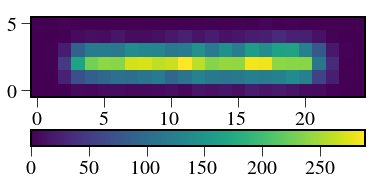

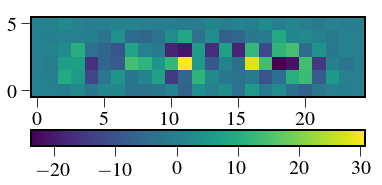

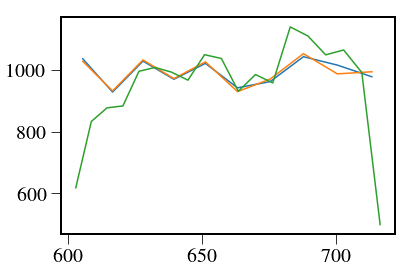

In [282]:
subim = np.sum(psflet_subarr,axis=0)
calcSNRtotal(Nelec=1000,
        subim=subim,
        psflet_subarr=psflet_subarr,
        pixnoise=0,
        npix=5,
        plot=True)

# TODO: Use a finer sampling for the least squares (regenerate the polychrome)